In [22]:
import pandas as pd
import numpy as np

from datetime import datetime,timedelta
import seaborn as sns
import pylab as plt

import sys
sys.path.insert(1,'../../scripts')
import plots

In [6]:
def calculate_moving_average(data, date, window_days):
    """
    Calculate the moving average of steps for a specified window around a given date,
    excluding the date itself.
    """
    window_start = date - timedelta(days=window_days)
    window_end = date + timedelta(days=window_days)
    
    # Filter data within the window but exclude the clinic visit date
    window_data = data[(data['Date'] >= window_start) & (data['Date'] <= window_end) & (data['Date'] != date)]
    
    # Calculate average steps in the window
    average_steps = window_data['Steps'].mean()
    return average_steps

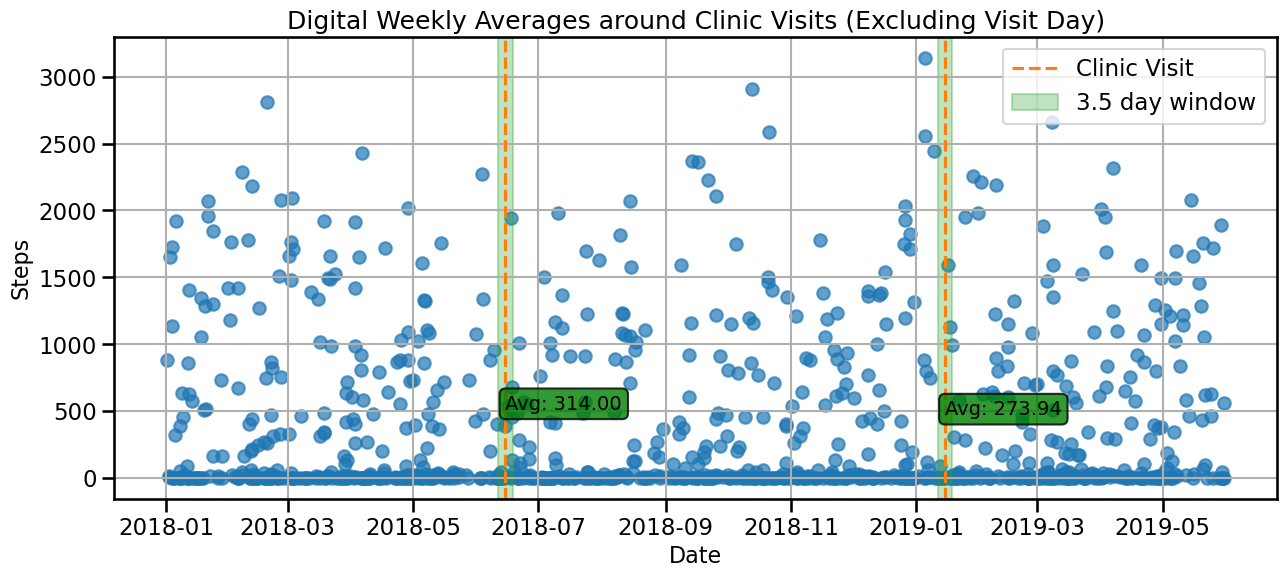

In [29]:
# Adjusting the synthetic data generation according to the new requirements
window_days = 3.5
# New date range: 2018 to 2020
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 5, 31)
total_hours = int((end_date - start_date).total_seconds() / 3600)

# Generate step data
steps_per_hour = np.random.normal(loc=300, scale=1000, size=total_hours)
steps_per_hour = np.clip(steps_per_hour, 0, 6000)

# Adjust step count for nighttime hours
for i in range(total_hours):
    hour_of_day = (start_date + timedelta(hours=i)).hour
    if 23 <= hour_of_day or hour_of_day < 7:
        steps_per_hour[i] = np.clip(np.random.pareto(a=3, size=1) * 40, 0, 200)

# Create the DataFrame
dates = [start_date + timedelta(hours=i) for i in range(total_hours)]
step_data = pd.DataFrame({'Date': dates, 'Steps': steps_per_hour})

# Introduce a missing data rate randomly
missing_rate = 0.80
for i in range(len(step_data)):
    if np.random.rand() < missing_rate:
        step_data.loc[i, 'Steps'] = np.nan
        if i + 1 < len(step_data) and np.random.rand() < 0.75:  # 75% chance the next hour is also missing
            step_data.loc[i + 1, 'Steps'] = np.nan

# Generate clinic visit data for UPDRS II at two time points, about 6 months apart
clinic_visits = [datetime(2018, 6, 15), datetime(2019, 1, 15)]

# Add clinic visits to the DataFrame
step_data['Clinic_Visit'] = step_data['Date'].isin(clinic_visits)

# Calculate moving averages for each clinic visit
averages = {}
for visit in clinic_visits:
    avg_steps = calculate_moving_average(step_data, visit, window_days)
    averages[visit] = avg_steps

# Now plot with the updated data and settings
plt.figure(figsize=(15, 6))
plots.plot_context()
# Increased font size
plt.rcParams.update({'font.size': 14})

plt.scatter(step_data['Date'], step_data['Steps'], alpha=0.7, color='#1f77b4')  # blue color

# Highlight clinic visits
for visit,name in zip(clinic_visits,['1st','2nd']):
    plt.axvline(x=visit, color='#ff7f0e', linestyle='--', label=f'Clinic Visit')  # orange color
    # Highlight the window for each clinic visit
    plt.axvspan(visit - timedelta(days=window_days), visit + timedelta(days=window_days), color='#2ca02c', alpha=0.3,label='3.5 day window')  # green color
    # Annotate the average steps
    plt.annotate(f'Avg: {averages[visit]:.2f}', xy=(visit, averages[visit]), xytext=(visit, averages[visit] + 200),bbox=dict(boxstyle='round', facecolor='green', alpha=0.8))

plt.xlabel('Date')
plt.ylabel('Steps')
plt.title('Digital Weekly Averages around Clinic Visits (Excluding Visit Day)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)
plt.savefig('/scratch/c.c21013066/images/paper/digitalPPMI/schematic_weekly_averages.png',dpi=300,bbox_inches='tight')
plt.savefig('/scratch/c.c21013066/images/paper/digitalPPMI/schematic_weekly_averages.pdf',dpi=300,bbox_inches='tight')